In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path

from renewable_data_load import *

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Configuration

In [2]:
# Analysis parameters
domain = "d02"
variable = "cf"
reference_gwl = 0.8
target_gwl = 2.0
simulation = "ec-earth3"

# Available simulations
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]

# Data directory
data_dir = Path("../../data/drought_masks")

## Load Drought Masks

In [3]:
def load_drought_mask(resource, module, domain, variable, simulation, gwl, data_dir="../../data/drought_masks"):
    """
    Load a drought mask from zarr store.
    
    Parameters
    ----------
    resource : str
        Resource type ('pv' or 'windpower')
    module : str
        Module type ('utility', 'distributed', 'onshore', 'offshore')
    domain : str
        Domain ('d02' or 'd03')
    variable : str
        Variable ('cf' or 'gen')
    simulation : str
        Climate model simulation name
    gwl : float
        Global warming level (0.8, 1.5, 2.0, 3.0, etc.)
    data_dir : str or Path
        Directory containing drought mask files
        
    Returns
    -------
    xr.DataArray
        Drought mask (1 = drought, 0 = no drought)
    """
    mask_file = f"{resource}_{module}_{domain}_{variable}_{simulation}_gwl{gwl}_drought_mask_only.zarr"
    mask_path = Path(data_dir) / mask_file
    
    if not mask_path.exists():
        raise FileNotFoundError(f"Drought mask not found: {mask_path}")
    
    # Open zarr store with consolidated metadata
    ds = xr.open_zarr(mask_path, consolidated=True)
    
    return ds['drought_mask']

In [4]:
# Load drought masks for solar and wind
print(f"Loading drought masks for {simulation} at GWL {target_gwl}°C...")

solar_mask = load_drought_mask(
    resource="pv",
    module="utility",
    domain=domain,
    variable=variable,
    simulation=simulation,
    gwl=target_gwl,
    data_dir=data_dir
)

wind_mask = load_drought_mask(
    resource="windpower",
    module="onshore",
    domain=domain,
    variable=variable,
    simulation=simulation,
    gwl=target_gwl,
    data_dir=data_dir
)

print(f"Solar mask shape: {solar_mask.shape}")
print(f"Wind mask shape: {wind_mask.shape}")
print(f"Time period: {solar_mask.time.values[0]} to {solar_mask.time.values[-1]}")

Loading drought masks for ec-earth3 at GWL 2.0°C...
Solar mask shape: (320, 250, 10950)
Wind mask shape: (320, 250, 10950)
Time period: 2017-01-01 00:00:00 to 2046-12-31 00:00:00


## Coincident Drought Analysis Functions

In [5]:
def analyze_coincident_droughts(solar_mask, wind_mask, x_idx, y_idx):
    """
    Analyze coincident droughts at a specific location.
    
    Parameters
    ----------
    solar_mask : xr.DataArray
        Solar drought mask (1 = drought, 0 = no drought)
    wind_mask : xr.DataArray
        Wind drought mask (1 = drought, 0 = no drought)
    x_idx : int
        X coordinate index
    y_idx : int
        Y coordinate index
        
    Returns
    -------
    dict
        Dictionary containing coincident drought metrics
    """
    # Extract location data
    solar_loc = solar_mask.isel(x=x_idx, y=y_idx)
    wind_loc = wind_mask.isel(x=x_idx, y=y_idx)
    
    # Ensure same time coordinates
    time_intersection = np.intersect1d(solar_loc.time.values, wind_loc.time.values)
    solar_loc = solar_loc.sel(time=time_intersection)
    wind_loc = wind_loc.sel(time=time_intersection)
    
    # Calculate coincident drought mask (both resources in drought)
    coincident_mask = (solar_loc == 1) & (wind_loc == 1)
    
    # Calculate metrics
    total_days = len(time_intersection)
    solar_drought_days = int(solar_loc.sum().values)
    wind_drought_days = int(wind_loc.sum().values)
    coincident_days = int(coincident_mask.sum().values)
    
    # Frequencies
    solar_freq = solar_drought_days / total_days
    wind_freq = wind_drought_days / total_days
    coincident_freq = coincident_days / total_days
    
    # Conditional probability: P(wind drought | solar drought)
    prob_wind_given_solar = coincident_days / solar_drought_days if solar_drought_days > 0 else 0
    
    # Conditional probability: P(solar drought | wind drought)
    prob_solar_given_wind = coincident_days / wind_drought_days if wind_drought_days > 0 else 0
    
    # Independence test: if independent, P(both) = P(solar) * P(wind)
    expected_coincident_freq = solar_freq * wind_freq
    enrichment_factor = coincident_freq / expected_coincident_freq if expected_coincident_freq > 0 else 0
    
    results = {
        'x_idx': x_idx,
        'y_idx': y_idx,
        'total_days': total_days,
        'solar_drought_days': solar_drought_days,
        'wind_drought_days': wind_drought_days,
        'coincident_days': coincident_days,
        'solar_freq': solar_freq,
        'wind_freq': wind_freq,
        'coincident_freq': coincident_freq,
        'prob_wind_given_solar': prob_wind_given_solar,
        'prob_solar_given_wind': prob_solar_given_wind,
        'expected_coincident_freq': expected_coincident_freq,
        'enrichment_factor': enrichment_factor,
        'coincident_mask': coincident_mask
    }
    
    return results

In [6]:
def print_coincident_summary(results):
    """
    Print a summary of coincident drought analysis results.
    """
    print(f"\n{'='*60}")
    print(f"Coincident Drought Analysis")
    print(f"Location: x={results['x_idx']}, y={results['y_idx']}")
    print(f"{'='*60}\n")
    
    print(f"Total days analyzed: {results['total_days']:,}")
    print(f"\nIndividual Resource Droughts:")
    print(f"  Solar drought days:    {results['solar_drought_days']:,} ({results['solar_freq']:.1%})")
    print(f"  Wind drought days:     {results['wind_drought_days']:,} ({results['wind_freq']:.1%})")
    
    print(f"\nCoincident Droughts:")
    print(f"  Both in drought:       {results['coincident_days']:,} ({results['coincident_freq']:.1%})")
    print(f"  Expected (if indep.):  {results['expected_coincident_freq']:.1%}")
    print(f"  Enrichment factor:     {results['enrichment_factor']:.2f}x")
    
    print(f"\nConditional Probabilities:")
    print(f"  P(wind drought | solar drought): {results['prob_wind_given_solar']:.1%}")
    print(f"  P(solar drought | wind drought): {results['prob_solar_given_wind']:.1%}")
    
    if results['enrichment_factor'] > 1.2:
        print(f"\n⚠️  Droughts are POSITIVELY correlated (occur together more than expected)")
    elif results['enrichment_factor'] < 0.8:
        print(f"\n✓  Droughts are NEGATIVELY correlated (occur together less than expected)")
    else:
        print(f"\n→  Droughts are approximately INDEPENDENT")

## Example: Single Location Analysis

In [7]:
# Choose a test location (San Bernardino area)
x_idx, y_idx = 66, 116

# Analyze coincident droughts
results = analyze_coincident_droughts(solar_mask, wind_mask, x_idx, y_idx)

# Print summary
print_coincident_summary(results)


Coincident Drought Analysis
Location: x=66, y=116

Total days analyzed: 10,950

Individual Resource Droughts:
  Solar drought days:    962 (8.8%)
  Wind drought days:     989 (9.0%)

Coincident Droughts:
  Both in drought:       245 (2.2%)
  Expected (if indep.):  0.8%
  Enrichment factor:     2.82x

Conditional Probabilities:
  P(wind drought | solar drought): 25.5%
  P(solar drought | wind drought): 24.8%

⚠️  Droughts are POSITIVELY correlated (occur together more than expected)


## Compare Warming Levels

Compare coincident drought characteristics between reference (0.8°C) and future (2.0°C) warming levels.

In [13]:
# Load drought masks for reference warming level (0.8°C)
print(f"Loading drought masks for {simulation} at GWL 0.8°C...")

solar_mask_ref = load_drought_mask(
    resource="pv",
    module="utility",
    domain=domain,
    variable=variable,
    simulation=simulation,
    gwl=0.8,
    data_dir=data_dir
)

wind_mask_ref = load_drought_mask(
    resource="windpower",
    module="onshore",
    domain=domain,
    variable=variable,
    simulation=simulation,
    gwl=0.8,
    data_dir=data_dir
)

# Analyze coincident droughts at the same location for both warming levels
results_ref = analyze_coincident_droughts(solar_mask_ref, wind_mask_ref, x_idx, y_idx)
results_fut = analyze_coincident_droughts(solar_mask, wind_mask, x_idx, y_idx)

# Create comparison DataFrame
warming_comparison = pd.DataFrame([
    {
        'Warming Level': '0.8°C (Reference)',
        'Solar Freq (%)': f"{results_ref['solar_freq']*100:.1f}",
        'Wind Freq (%)': f"{results_ref['wind_freq']*100:.1f}",
        'Coincident Freq (%)': f"{results_ref['coincident_freq']*100:.1f}",
        'Coincident Days': results_ref['coincident_days'],
        'Enrichment': f"{results_ref['enrichment_factor']:.2f}x",
        'P(Wind|Solar) (%)': f"{results_ref['prob_wind_given_solar']*100:.1f}",
    },
    {
        'Warming Level': '2.0°C (Future)',
        'Solar Freq (%)': f"{results_fut['solar_freq']*100:.1f}",
        'Wind Freq (%)': f"{results_fut['wind_freq']*100:.1f}",
        'Coincident Freq (%)': f"{results_fut['coincident_freq']*100:.1f}",
        'Coincident Days': results_fut['coincident_days'],
        'Enrichment': f"{results_fut['enrichment_factor']:.2f}x",
        'P(Wind|Solar) (%)': f"{results_fut['prob_wind_given_solar']*100:.1f}",
    }
])

print(f"\n{'='*80}")
print(f"Warming Level Comparison at Location (x={x_idx}, y={y_idx})")
print(f"Simulation: {simulation}")
print(f"{'='*80}\n")
print(warming_comparison.to_string(index=False))

# Calculate changes
solar_change = (results_fut['solar_freq'] - results_ref['solar_freq']) / results_ref['solar_freq'] * 100
wind_change = (results_fut['wind_freq'] - results_ref['wind_freq']) / results_ref['wind_freq'] * 100
coincident_change = (results_fut['coincident_freq'] - results_ref['coincident_freq']) / results_ref['coincident_freq'] * 100

print(f"\n{'='*80}")
print(f"Changes from 0.8°C to 2.0°C:")
print(f"  Solar drought frequency:      {solar_change:+.1f}%")
print(f"  Wind drought frequency:       {wind_change:+.1f}%")
print(f"  Coincident drought frequency: {coincident_change:+.1f}%")
print(f"{'='*80}")

Loading drought masks for ec-earth3 at GWL 0.8°C...

Warming Level Comparison at Location (x=66, y=116)
Simulation: ec-earth3

    Warming Level Solar Freq (%) Wind Freq (%) Coincident Freq (%)  Coincident Days Enrichment P(Wind|Solar) (%)
0.8°C (Reference)            8.9           8.6                 2.0              220      2.63x              22.6
   2.0°C (Future)            8.8           9.0                 2.2              245      2.82x              25.5

Changes from 0.8°C to 2.0°C:
  Solar drought frequency:      -1.1%
  Wind drought frequency:       +5.1%
  Coincident drought frequency: +11.4%


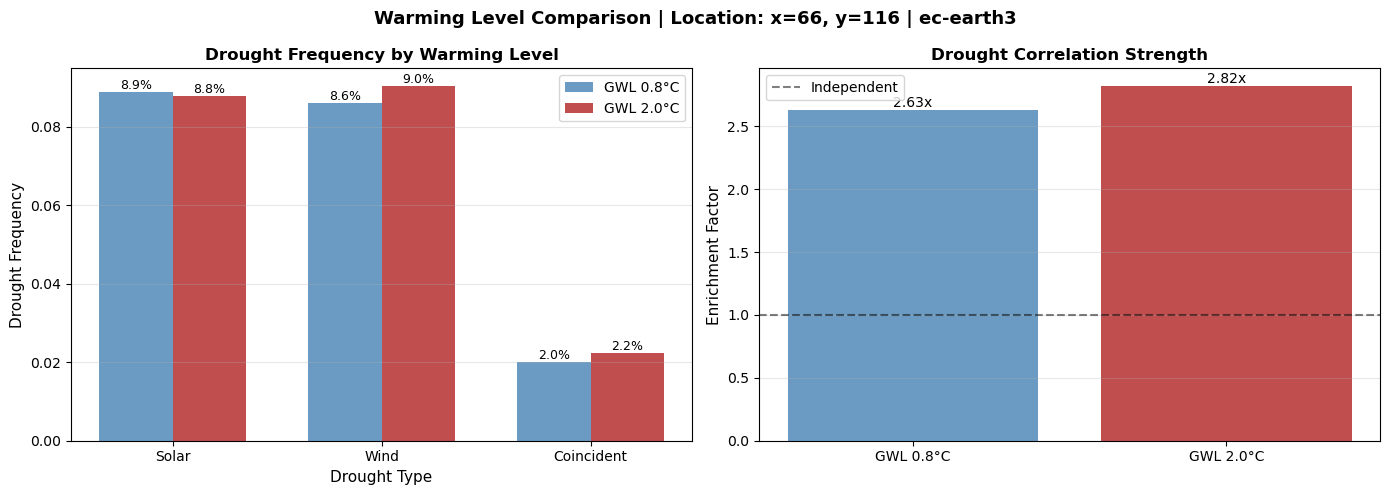

In [14]:
# Visualize warming level comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Drought frequency comparison
categories = ['Solar', 'Wind', 'Coincident']
ref_freqs = [results_ref['solar_freq'], results_ref['wind_freq'], results_ref['coincident_freq']]
fut_freqs = [results_fut['solar_freq'], results_fut['wind_freq'], results_fut['coincident_freq']]

x_pos = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, ref_freqs, width, label='GWL 0.8°C', color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x_pos + width/2, fut_freqs, width, label='GWL 2.0°C', color='firebrick', alpha=0.8)

axes[0].set_xlabel('Drought Type', fontsize=11)
axes[0].set_ylabel('Drought Frequency', fontsize=11)
axes[0].set_title('Drought Frequency by Warming Level', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom', fontsize=9)

# Enrichment factor comparison
enrichment_data = [results_ref['enrichment_factor'], results_fut['enrichment_factor']]
colors = ['steelblue', 'firebrick']
labels = ['GWL 0.8°C', 'GWL 2.0°C']

bars = axes[1].bar(labels, enrichment_data, color=colors, alpha=0.8)
axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Independent')
axes[1].set_ylabel('Enrichment Factor', fontsize=11)
axes[1].set_title('Drought Correlation Strength', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x', ha='center', va='bottom', fontsize=10)

fig.suptitle(f'Warming Level Comparison | Location: x={x_idx}, y={y_idx} | {simulation}',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Visualization: Time Series of Coincident Droughts

In [8]:
def plot_coincident_drought_timeseries(solar_mask, wind_mask, results, year_range=None):
    """
    Plot time series showing solar, wind, and coincident droughts.
    """
    x_idx = results['x_idx']
    y_idx = results['y_idx']
    
    # Extract location data
    solar_loc = solar_mask.isel(x=x_idx, y=y_idx)
    wind_loc = wind_mask.isel(x=x_idx, y=y_idx)
    coincident = results['coincident_mask']
    
    # Filter to year range if specified
    if year_range:
        time_slice = slice(f"{year_range[0]}-01-01", f"{year_range[1]}-12-31")
        solar_loc = solar_loc.sel(time=time_slice)
        wind_loc = wind_loc.sel(time=time_slice)
        coincident = coincident.sel(time=time_slice)
    
    # Create figure
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    # Plot solar droughts
    axes[0].fill_between(solar_loc.time.values, 0, solar_loc.values, 
                          where=(solar_loc.values == 1), color='orange', alpha=0.6, label='Solar drought')
    axes[0].set_ylabel('Solar\nDrought', fontsize=11)
    axes[0].set_ylim(-0.1, 1.1)
    axes[0].set_yticks([0, 1])
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')
    
    # Plot wind droughts
    axes[1].fill_between(wind_loc.time.values, 0, wind_loc.values,
                          where=(wind_loc.values == 1), color='skyblue', alpha=0.6, label='Wind drought')
    axes[1].set_ylabel('Wind\nDrought', fontsize=11)
    axes[1].set_ylim(-0.1, 1.1)
    axes[1].set_yticks([0, 1])
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')
    
    # Plot coincident droughts
    axes[2].fill_between(coincident.time.values, 0, coincident.values.astype(int),
                          where=(coincident.values == 1), color='darkred', alpha=0.7, label='Both in drought')
    axes[2].set_ylabel('Coincident\nDrought', fontsize=11)
    axes[2].set_ylim(-0.1, 1.1)
    axes[2].set_yticks([0, 1])
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='upper right')
    
    # Plot combined view
    axes[3].fill_between(solar_loc.time.values, 0, 1, where=(solar_loc.values == 1), 
                          color='orange', alpha=0.3, label='Solar only')
    axes[3].fill_between(wind_loc.time.values, 0, 1, where=(wind_loc.values == 1),
                          color='skyblue', alpha=0.3, label='Wind only')
    axes[3].fill_between(coincident.time.values, 0, 1, where=(coincident.values == 1),
                          color='darkred', alpha=0.7, label='Both')
    axes[3].set_ylabel('Combined\nView', fontsize=11)
    axes[3].set_ylim(-0.1, 1.1)
    axes[3].set_yticks([0, 1])
    axes[3].set_xlabel('Time', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    axes[3].legend(loc='upper right', ncol=3)
    
    fig.suptitle(f'Coincident Drought Analysis\nLocation: x={x_idx}, y={y_idx} | {simulation} | GWL {target_gwl}°C',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    return fig

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

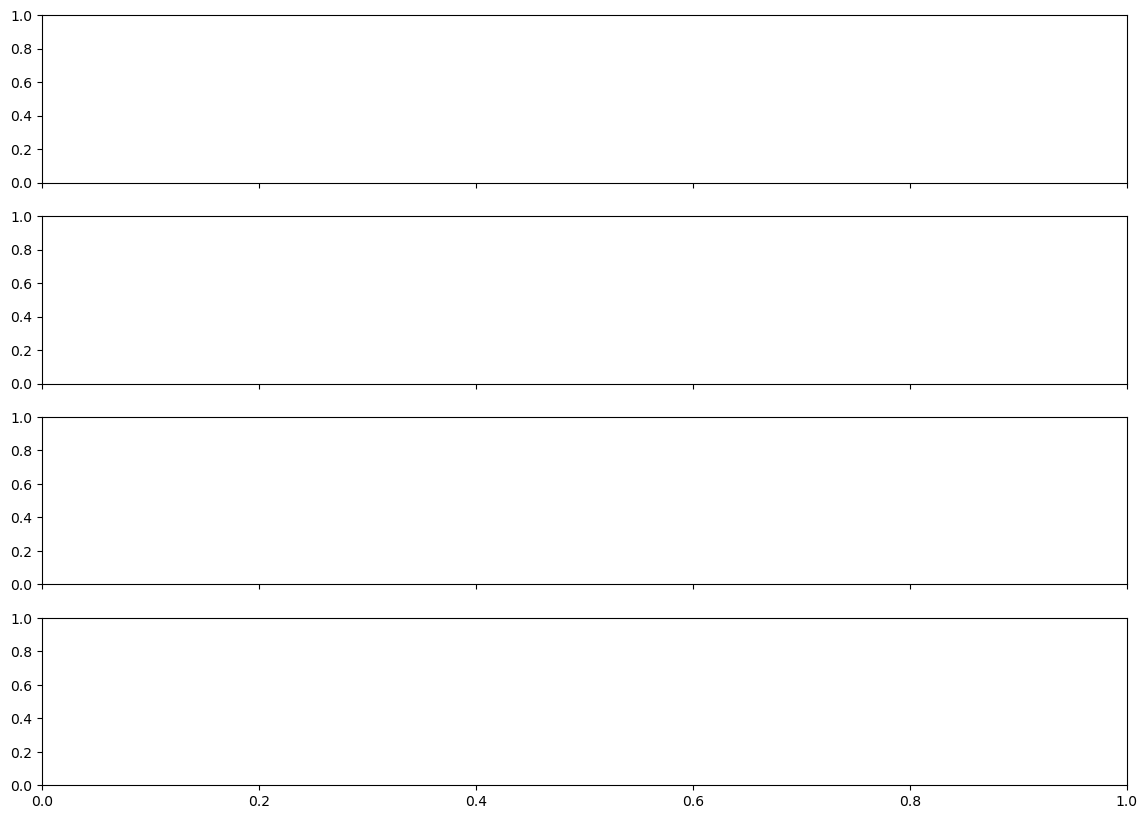

In [9]:
# Plot a 5-year window
fig = plot_coincident_drought_timeseries(solar_mask, wind_mask, results, year_range=(2035, 2040))
plt.show()

## Spatial Analysis: Coincident Drought Frequency Map

In [10]:
def compute_spatial_coincident_frequency(solar_mask, wind_mask):
    """
    Compute coincident drought frequency for all grid cells.
    
    Returns
    -------
    xr.DataArray
        Coincident drought frequency (0-1) at each location
    """
    # Ensure same time coordinates
    time_intersection = np.intersect1d(solar_mask.time.values, wind_mask.time.values)
    solar_aligned = solar_mask.sel(time=time_intersection)
    wind_aligned = wind_mask.sel(time=time_intersection)
    
    # Coincident drought mask (both in drought)
    coincident_mask = (solar_aligned == 1) & (wind_aligned == 1)
    
    # Calculate frequency (mean over time)
    coincident_freq = coincident_mask.mean(dim='time')
    
    return coincident_freq

In [11]:
print("Computing spatial coincident drought frequency...")
coincident_freq_map = compute_spatial_coincident_frequency(solar_mask, wind_mask)
print("Done!")

Computing spatial coincident drought frequency...
Done!


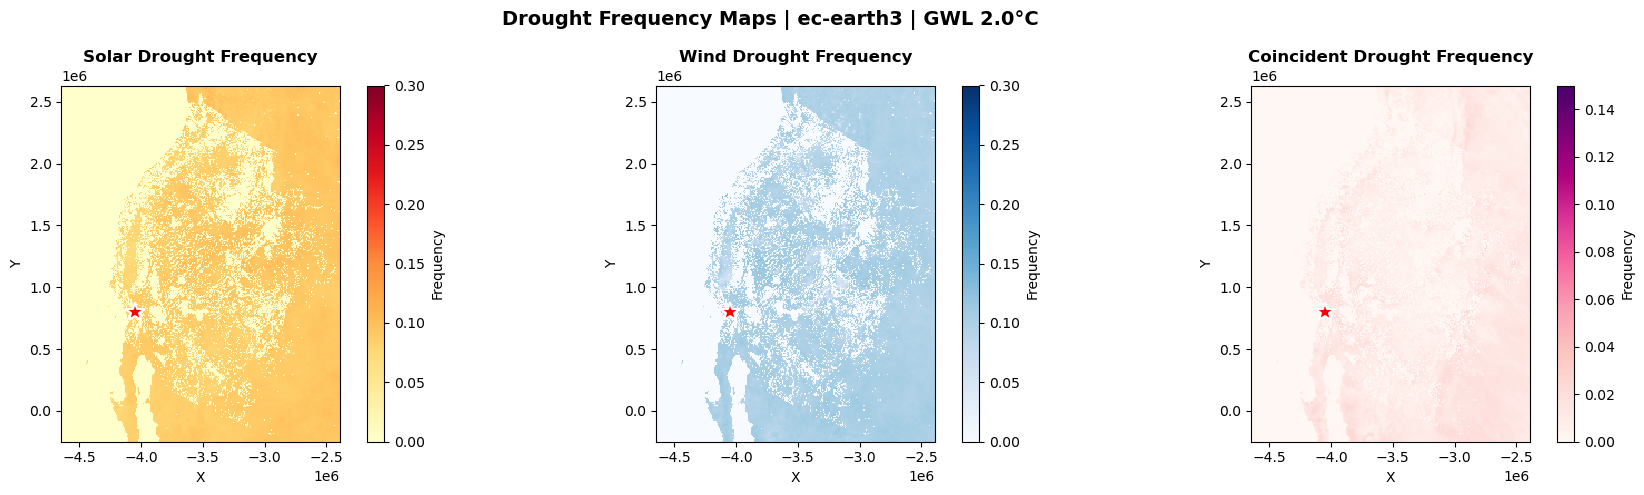

In [12]:
# Plot spatial map
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Solar drought frequency
solar_freq_map = solar_mask.mean(dim='time')
im1 = axes[0].pcolormesh(solar_freq_map.x, solar_freq_map.y, solar_freq_map.values,
                         cmap='YlOrRd', vmin=0, vmax=0.3, shading='auto')
axes[0].set_title('Solar Drought Frequency', fontsize=12, fontweight='bold')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Frequency')

# Wind drought frequency
wind_freq_map = wind_mask.mean(dim='time')
im2 = axes[1].pcolormesh(wind_freq_map.x, wind_freq_map.y, wind_freq_map.values,
                         cmap='Blues', vmin=0, vmax=0.3, shading='auto')
axes[1].set_title('Wind Drought Frequency', fontsize=12, fontweight='bold')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Frequency')

# Coincident drought frequency
im3 = axes[2].pcolormesh(coincident_freq_map.x, coincident_freq_map.y, coincident_freq_map.values,
                         cmap='RdPu', vmin=0, vmax=0.15, shading='auto')
axes[2].set_title('Coincident Drought Frequency', fontsize=12, fontweight='bold')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].set_aspect('equal')
plt.colorbar(im3, ax=axes[2], label='Frequency')

# Mark analyzed location
for ax in axes:
    ax.plot(solar_mask.x[x_idx], solar_mask.y[y_idx], 'r*', markersize=15, 
            markeredgecolor='white', markeredgewidth=1.5)

fig.suptitle(f'Drought Frequency Maps | {simulation} | GWL {target_gwl}°C',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Enrichment Factor Map

Shows whether coincident droughts occur more (>1) or less (<1) frequently than expected if droughts were independent.

In [ ]:
# Calculate expected frequency under independence
expected_freq = solar_freq_map * wind_freq_map

# Calculate enrichment factor
enrichment_map = coincident_freq_map / expected_freq
enrichment_map = enrichment_map.where(expected_freq > 0.001)  # Mask very low expected values

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.pcolormesh(enrichment_map.x, enrichment_map.y, enrichment_map.values,
                   cmap='RdBu_r', vmin=0.5, vmax=1.5, shading='auto')
ax.set_title(f'Coincident Drought Enrichment Factor\n{simulation} | GWL {target_gwl}°C',
             fontsize=13, fontweight='bold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Enrichment Factor\n(<1: anti-correlated, 1: independent, >1: correlated)', 
               fontsize=10)

# Mark analyzed location
ax.plot(solar_mask.x[x_idx], solar_mask.y[y_idx], 'k*', markersize=15,
        markeredgecolor='white', markeredgewidth=2)

plt.tight_layout()
plt.show()

## Multi-Location Analysis

In [ ]:
# Define multiple test locations
test_locations = [
    (66, 116, "San Bernardino"),
    (124, 118, "Central Valley"),
    (104, 224, "Bay Area"),
    (57, 160, "LA Basin"),
]

# Analyze all locations
multi_results = []
for x_idx, y_idx, name in test_locations:
    results = analyze_coincident_droughts(solar_mask, wind_mask, x_idx, y_idx)
    results['location_name'] = name
    multi_results.append(results)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Location': r['location_name'],
        'X': r['x_idx'],
        'Y': r['y_idx'],
        'Solar Freq (%)': f"{r['solar_freq']*100:.1f}",
        'Wind Freq (%)': f"{r['wind_freq']*100:.1f}",
        'Coincident Freq (%)': f"{r['coincident_freq']*100:.1f}",
        'Enrichment': f"{r['enrichment_factor']:.2f}x",
        'P(Wind|Solar) (%)': f"{r['prob_wind_given_solar']*100:.1f}",
    }
    for r in multi_results
])

print(f"\nCoincident Drought Analysis Across Locations")
print(f"Simulation: {simulation} | GWL: {target_gwl}°C\n")
print(comparison_df.to_string(index=False))

## Seasonal Analysis

In [ ]:
def seasonal_coincident_analysis(solar_mask, wind_mask, x_idx, y_idx):
    """
    Analyze coincident droughts by season.
    """
    # Extract location data
    solar_loc = solar_mask.isel(x=x_idx, y=y_idx)
    wind_loc = wind_mask.isel(x=x_idx, y=y_idx)
    
    # Align times
    time_intersection = np.intersect1d(solar_loc.time.values, wind_loc.time.values)
    solar_loc = solar_loc.sel(time=time_intersection)
    wind_loc = wind_loc.sel(time=time_intersection)
    
    # Add season coordinate
    seasons = solar_loc.time.dt.season
    
    seasonal_results = {}
    for season in ['DJF', 'MAM', 'JJA', 'SON']:
        season_mask = seasons == season
        solar_season = solar_loc.where(season_mask, drop=True)
        wind_season = wind_loc.where(season_mask, drop=True)
        
        coincident = (solar_season == 1) & (wind_season == 1)
        
        seasonal_results[season] = {
            'days': len(solar_season),
            'solar_freq': float(solar_season.mean()),
            'wind_freq': float(wind_season.mean()),
            'coincident_freq': float(coincident.mean())
        }
    
    return seasonal_results

In [ ]:
# Analyze seasonality at example location
seasonal_results = seasonal_coincident_analysis(solar_mask, wind_mask, x_idx, y_idx)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

seasons = list(seasonal_results.keys())
x_pos = np.arange(len(seasons))
width = 0.25

solar_freqs = [seasonal_results[s]['solar_freq'] for s in seasons]
wind_freqs = [seasonal_results[s]['wind_freq'] for s in seasons]
coincident_freqs = [seasonal_results[s]['coincident_freq'] for s in seasons]

ax.bar(x_pos - width, solar_freqs, width, label='Solar', color='orange', alpha=0.7)
ax.bar(x_pos, wind_freqs, width, label='Wind', color='skyblue', alpha=0.7)
ax.bar(x_pos + width, coincident_freqs, width, label='Coincident', color='darkred', alpha=0.7)

ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Drought Frequency', fontsize=11)
ax.set_title(f'Seasonal Drought Frequency\nLocation: x={x_idx}, y={y_idx} | {simulation} | GWL {target_gwl}°C',
             fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(seasons)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Save Results

In [ ]:
# Save comparison table
output_dir = Path("../../data/coincident_droughts")
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / f"coincident_drought_analysis_{simulation}_gwl{target_gwl}.csv"
comparison_df.to_csv(output_file, index=False)
print(f"Saved results to: {output_file}")